# Testing image classification with vision transformer (ViT)

source: https://keras.io/examples/vision/image_classification_with_vision_transformer/

## Setup

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

2023-05-29 16:50:16.348071: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/beatrizcf/Engenharia/8Semestre/machine/breastCancerProject/breast_cancer_ML_project/.venv/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [4]:
# import ssl to download keras data
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

## Prepare the data

In [9]:
num_classes = 100
input_shape = (32, 32, 3)

(x_train_full, y_train_full), (x_test_full, y_test_full) = keras.datasets.cifar100.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


In [10]:
# Randomly select 1000 images for training
random_indices_train = np.random.choice(len(x_train_full), size=1000, replace=False)
x_train = x_train_full[random_indices_train]
y_train = y_train_full[random_indices_train]

# Randomly select 100 images for testing
random_indices_test = np.random.choice(len(x_test_full), size=100, replace=False)
x_test = x_test_full[random_indices_test]
y_test = y_test_full[random_indices_test]

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (1000, 32, 32, 3) - y_train shape: (1000, 1)
x_test shape: (100, 32, 32, 3) - y_test shape: (100, 1)


## Configure the hyperparameters

In [11]:
learning_rate = 0.001  # Learning rate for the optimizer
weight_decay = 0.0001  # Weight decay regularization parameter
batch_size = 256  # Number of samples in each training batch
num_epochs = 100  # Number of training epochs - complete pass through the entire training dataset
image_size = 72  # The size to which input images will be resized
patch_size = 6  # Size of the patches to be extracted from the input images
num_patches = (image_size // patch_size) ** 2  # Number of patches in the image grid
projection_dim = 64  # Dimensionality of the projected feature space in the self-attention layer
num_heads = 4  # Number of attention heads in the self-attention layer
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8  # Number of transformer layers
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier


## Use data augmentation

In [12]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

## Implement MLP

Multilayer perceptron (MLP) is a type of neural network that consists in one or more layers of interconnected nodes, called neurons. The first layer is the input layer, the last layer is the output layer and the layers in between are called the hidden layers, because it's not possible to predict their outputs. 

Training an MLP is normally done using an optimization algorithm called backpropagation, which calculates the gradients of the error with respect to the weights and updates them accordingly. There are basically 4 steps:

* 1st Step: Initialization
  * Assign random values to weights and biases.
  * The choice of initial values influences the behavior of the network.
  * In the absence of prior knowledge, weights and biases should have random and small uniformly distributed initial values.


* 2nd Step: Activation
  * Calculate the values of neurons in the hidden layer.
  * Calculate the values of neurons in the output layer.


* 3rd Step: Weight Training
  * Calculate the errors of neurons in the output and hidden layers.
  * Calculate the weight correction.
  * Update the weights of neurons in the output and hidden layers.


* 4th Step: Iteration
  * Repeat the process from step 2 until the error criterion is satisfied.

In [13]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:  # Iterate over the hidden_units list
        x = layers.Dense(units, activation=tf.nn.gelu)(x)  # Add a dense layer with specified units and GELU activation
        x = layers.Dropout(dropout_rate)(x)  # Add a dropout layer with specified dropout rate
    return x  # Return the output of the MLP


The mlp function implements a multilayer perceptron (MLP) with GELU activation and dropout regularization. It takes an input tensor x, hidden layer sizes specified by hidden_units, and a dropout rate. It adds dense layers with GELU activation and dropout layers to the model. The loop iterates over the hidden layer sizes, creating a stack of layers. The resulting tensor x is returned as the MLP's output. This function provides a flexible and customizable way to construct MLPs for various tasks.

## Implement patch creation as a layer

In [14]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size  # Initialize the patch_size attribute
    
    def call(self, images):
        batch_size = tf.shape(images)[0]  # Get the batch size of the input images
        
        # Extract patches from the images using specified parameters
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        
        patch_dims = patches.shape[-1]  # Get the number of dimensions of the patches
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])  # Reshape patches into a 2D tensor
        
        return patches  # Return the extracted and reshaped patches


Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


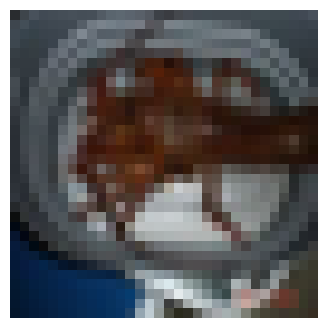

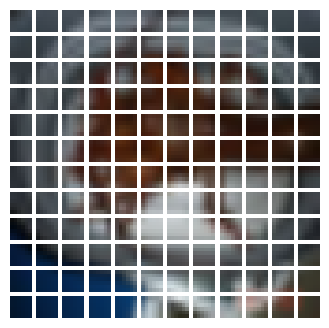

In [15]:
# display patches for a sample image
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

## Implement the patch encoding layer
The PatchEncoder layer will linearly transform a patch by projecting it into a vector of size projection_dim. In addition, it adds a learnable position embedding to the projected vector.

In [16]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches  # Number of patches in the input
        self.projection = layers.Dense(units=projection_dim)  # Linear projection layer
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )  # Positional embedding layer

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)  # Generate positions for positional encoding
        encoded = self.projection(patch) + self.position_embedding(positions)  # Combine projection and positional embedding
        return encoded  # Return the encoded patch


## Build the ViT model

In [17]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

## Compile, train, and evaluate the mode


In [18]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/100
4/4 [==============================] - 131s 26s/step - loss: 7.1379 - accuracy: 0.0122 - top-5-accuracy: 0.0489 - val_loss: 4.6395 - val_accuracy: 0.0000e+00 - val_top-5-accuracy: 0.0700
Epoch 2/100
4/4 [==============================] - 138s 38s/step - loss: 5.3708 - accuracy: 0.0189 - top-5-accuracy: 0.0922 - val_loss: 4.5789 - val_accuracy: 0.0200 - val_top-5-accuracy: 0.1100
Epoch 3/100
4/4 [==============================] - 193s 56s/step - loss: 4.9336 - accuracy: 0.0289 - top-5-accuracy: 0.0800 - val_loss: 4.5130 - val_accuracy: 0.0400 - val_top-5-accuracy: 0.1500
Epoch 4/100
4/4 [==============================] - 970s 315s/step - loss: 4.7856 - accuracy: 0.0367 - top-5-accuracy: 0.1189 - val_loss: 4.5041 - val_accuracy: 0.0100 - val_top-5-accuracy: 0.1000
Epoch 5/100
4/4 [==============================] - 139s 37s/step - loss: 4.6388 - accuracy: 0.0356 - top-5-accuracy: 0.1433 - val_loss: 4.4957 - val_accuracy: 0.0000e+00 - val_top-5-accuracy: 0.0700
Epoch 6/100
4/4 

KeyboardInterrupt: 